# Student Performance Predictor

## Import Dependencies

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

### Importing Dataset

In [141]:
df = pd.read_csv('../data/math_subject_grade_prediction.csv')

### Feature Engineering

In [142]:
df['Past_Performance_Grade'] = (df.G1 + df.G2) / 2
df['Parents_Education'] = (df.Medu + df.Fedu) / 2
df['Alcohol_Consumption'] = (df.Walc + df.Dalc)

In [143]:
df.drop(['school', 'sex','G1', 'G2', 'Medu', 'Fedu', 'Dalc', 'Walc', 'guardian', 'reason'], 
        axis=1, inplace=True)

In [144]:
df.columns=['Age', 'Locality', 'Family_Size', 'Parents_Cohab_Status', 'Mother_Job',
            'Father_Job', 'Home_to_School_Travel_Time', 'Weekly_Study_Time', 'Past_Class_Failure_Count', 
            'School_Support', 'Family_Support', 'Extra_Paid_Classes', 'Extra_Curr_Activities', 
            'Attended_Kindergarten', 'Higher_Edu', 'Internet', 'Dating', 'Family_Relationship', 
            'Freetime_After_School', 'Goes_Out', 'Current_Health_Status', 'School_Absences', 
            'Final_Grade', 'Past_Grade_Record', 'Parents_Education', 'Alcohol_Consumption']

### Feature Encoding

In [145]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
ohe = OneHotEncoder()
le = OrdinalEncoder()
rs = RobustScaler()

In [146]:
onehot_cols = ['Father_Job', 'Mother_Job']
ord_enc_cols = ['School_Support', 'Family_Support', 'Higher_Edu', 'Extra_Paid_Classes', 'Locality', 
                'Family_Size', 'Parents_Cohab_Status', 'Dating', 'Extra_Curr_Activities', 
                'Attended_Kindergarten', 'Internet']

one_hot_enc = OneHotEncoder(sparse_output=False)
ord_enc = OrdinalEncoder()
rob_scaler = RobustScaler()

In [147]:
onehot_encoded_cols = one_hot_enc.fit_transform(df[onehot_cols])
ord_encoded_cols = ord_enc.fit_transform(df[ord_enc_cols])

In [148]:
df[ord_enc_cols] = ord_encoded_cols

In [149]:
df[one_hot_enc.get_feature_names_out()] = onehot_encoded_cols

In [150]:
df.shape

(395, 36)

In [151]:
df.drop(onehot_cols, axis=1, inplace=True)

In [152]:
df.shape

(395, 34)

### Visualizing Feature Correlations

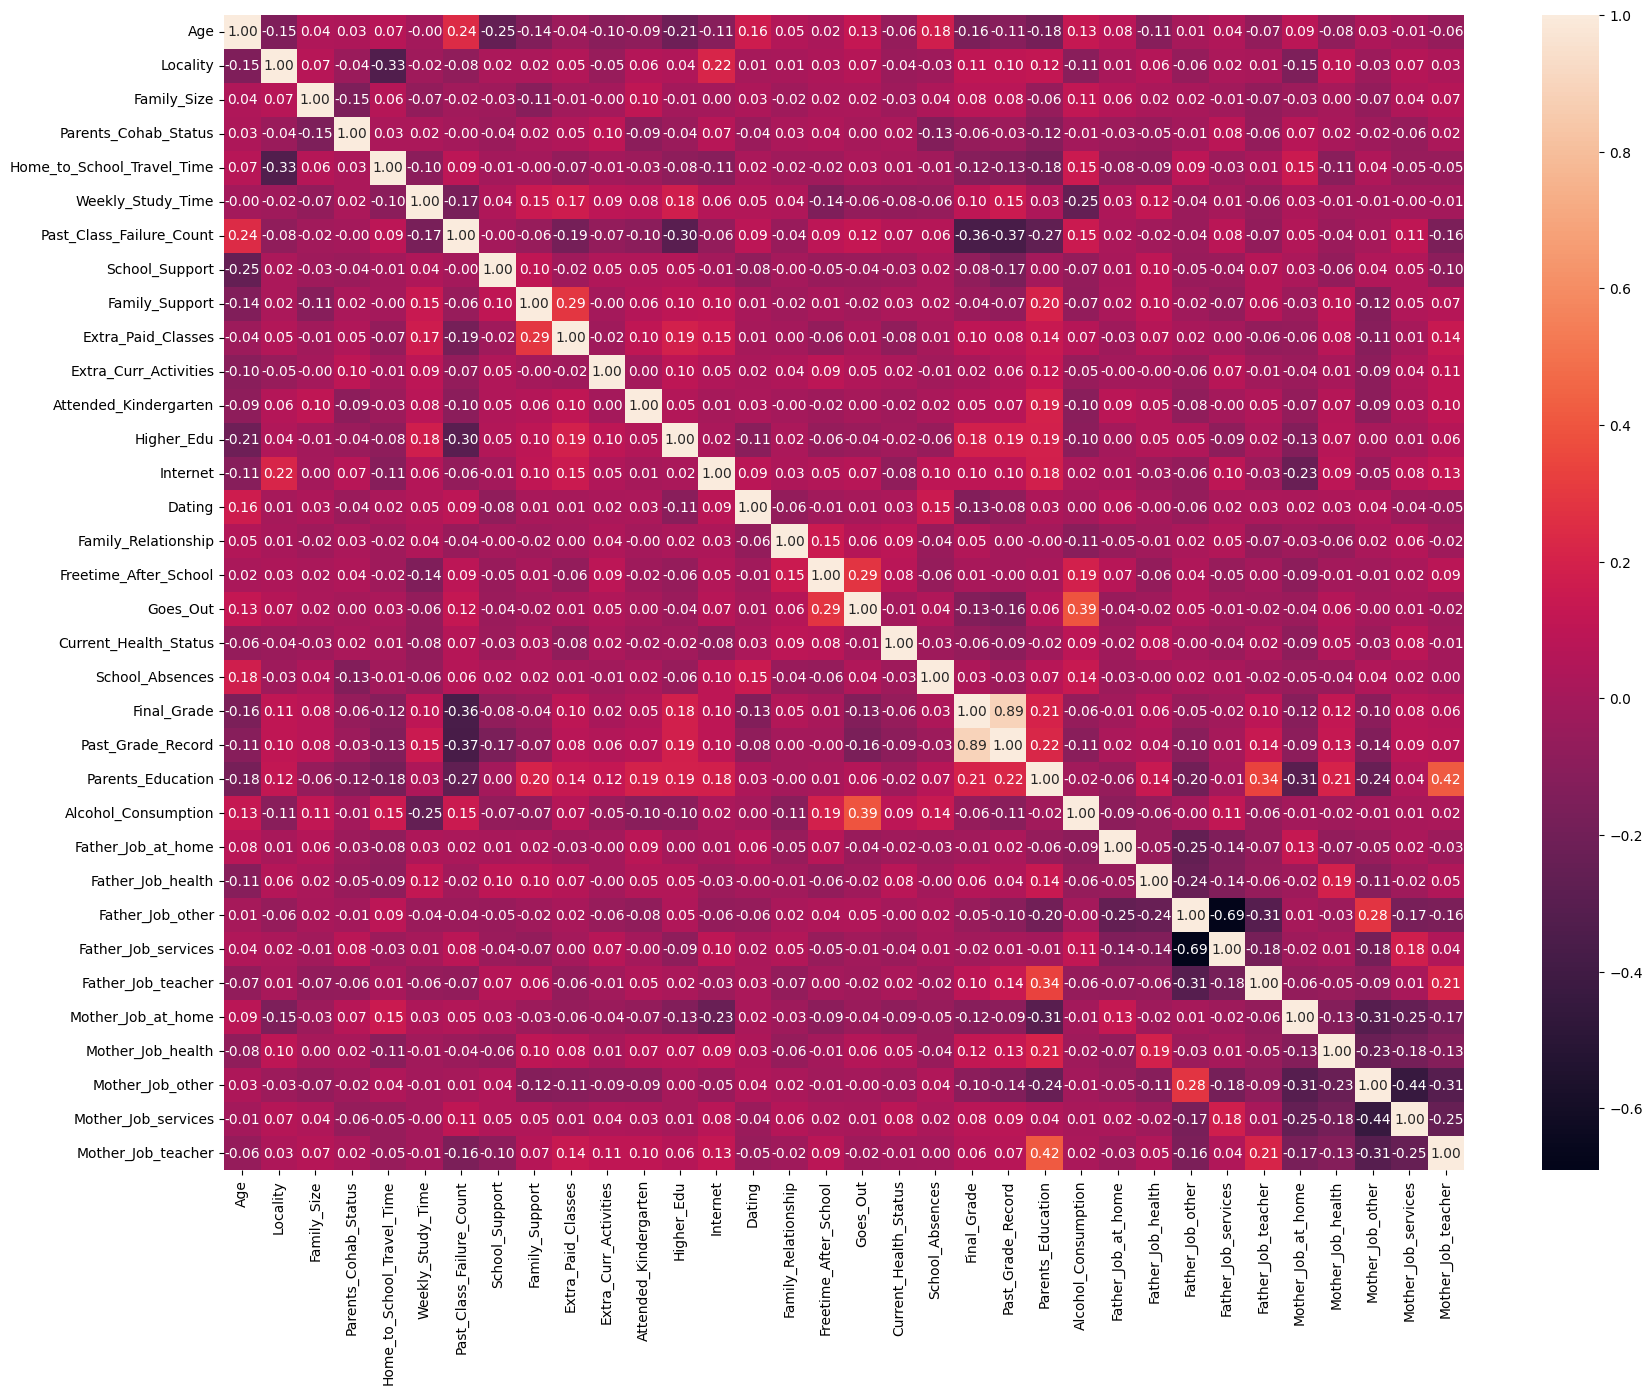

In [153]:
corr_matrix = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

### Dataset Splitting into Train and Test Sets

In [154]:
X = df.drop(['Final_Grade'], axis=1)
Y = df['Final_Grade']

### Feature Selection

In [155]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
k_best = SelectKBest(score_func=mutual_info_regression, k=15)
selected_features = k_best.fit(X, Y)
X_new = k_best.fit_transform(X,Y)

In [156]:
selected_features.get_feature_names_out()

array(['Age', 'Family_Size', 'Past_Class_Failure_Count',
       'Extra_Paid_Classes', 'Higher_Edu', 'Dating', 'Goes_Out',
       'School_Absences', 'Past_Grade_Record', 'Alcohol_Consumption',
       'Father_Job_services', 'Father_Job_teacher', 'Mother_Job_other',
       'Mother_Job_services', 'Mother_Job_teacher'], dtype=object)

In [157]:
X_new.shape

(395, 15)

In [158]:
X_best = df[selected_features.get_feature_names_out()]

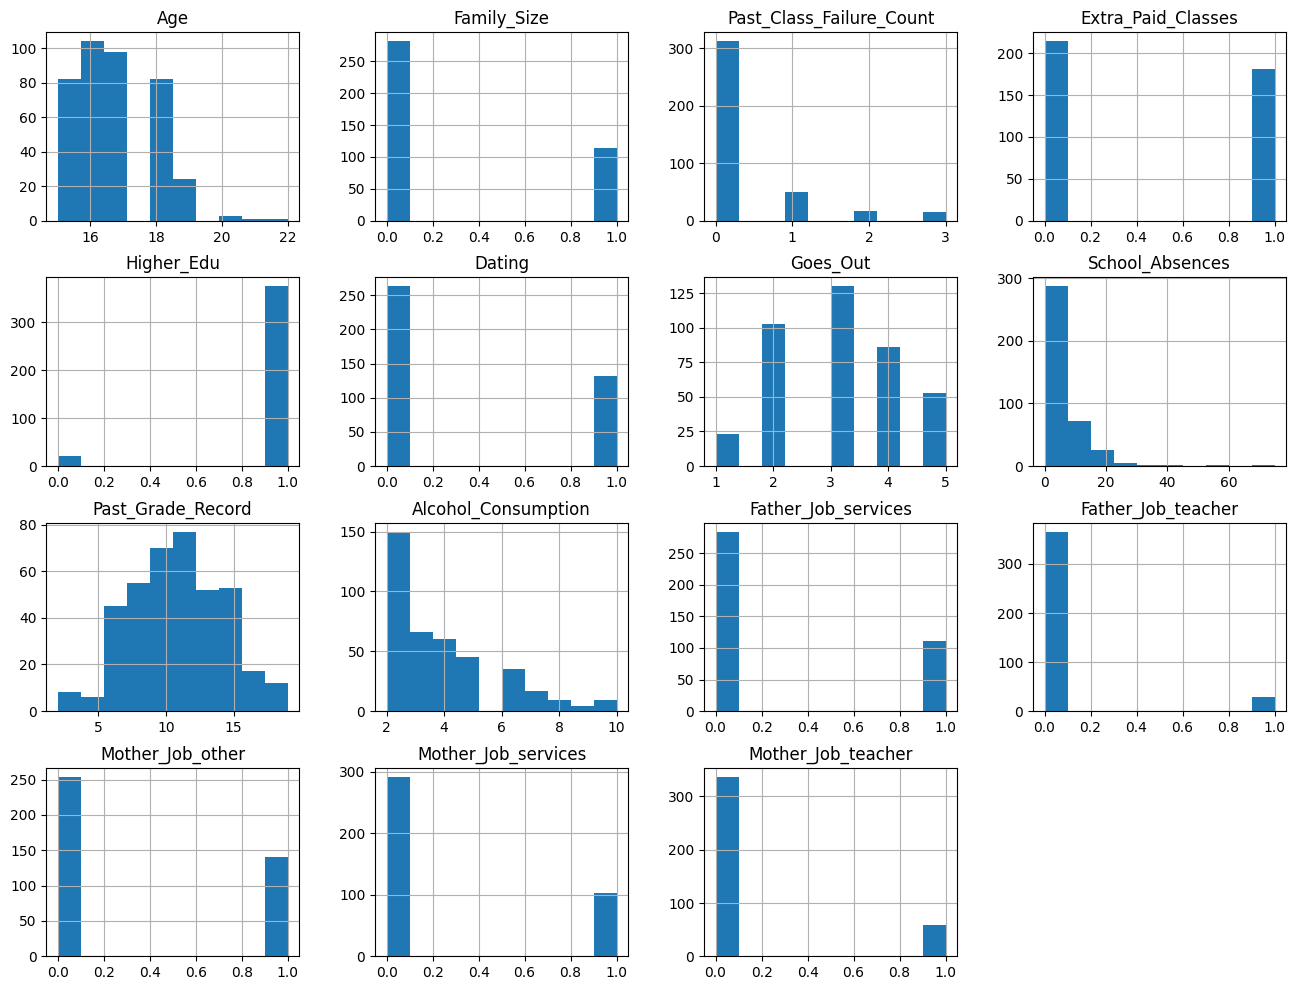

In [159]:
X_best.hist(figsize=(16, 12))
plt.show()

In [165]:
scaling_cols = ['Age', 'Past_Class_Failure_Count', 'Goes_Out',
       'School_Absences', 'Past_Grade_Record', 'Alcohol_Consumption']

### Dataset Scaling

In [166]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_best, Y, test_size=0.2, random_state=42)

In [167]:
x_train.columns

Index(['Age', 'Family_Size', 'Past_Class_Failure_Count', 'Extra_Paid_Classes',
       'Higher_Edu', 'Dating', 'Goes_Out', 'School_Absences',
       'Past_Grade_Record', 'Alcohol_Consumption', 'Father_Job_services',
       'Father_Job_teacher', 'Mother_Job_other', 'Mother_Job_services',
       'Mother_Job_teacher'],
      dtype='object')

In [168]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
scaler = QuantileTransformer()  # ---> highest RFR performance (RFR model performs best) 

x_train[scaling_cols] = scaler.fit_transform(x_train[scaling_cols])
x_test[scaling_cols] = scaler.transform(x_test[scaling_cols])

a:\AI-Projects\tools\miniconda3\envs\stats_ml\lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (316). n_quantiles is set to n_samples.
  warnings.warn(


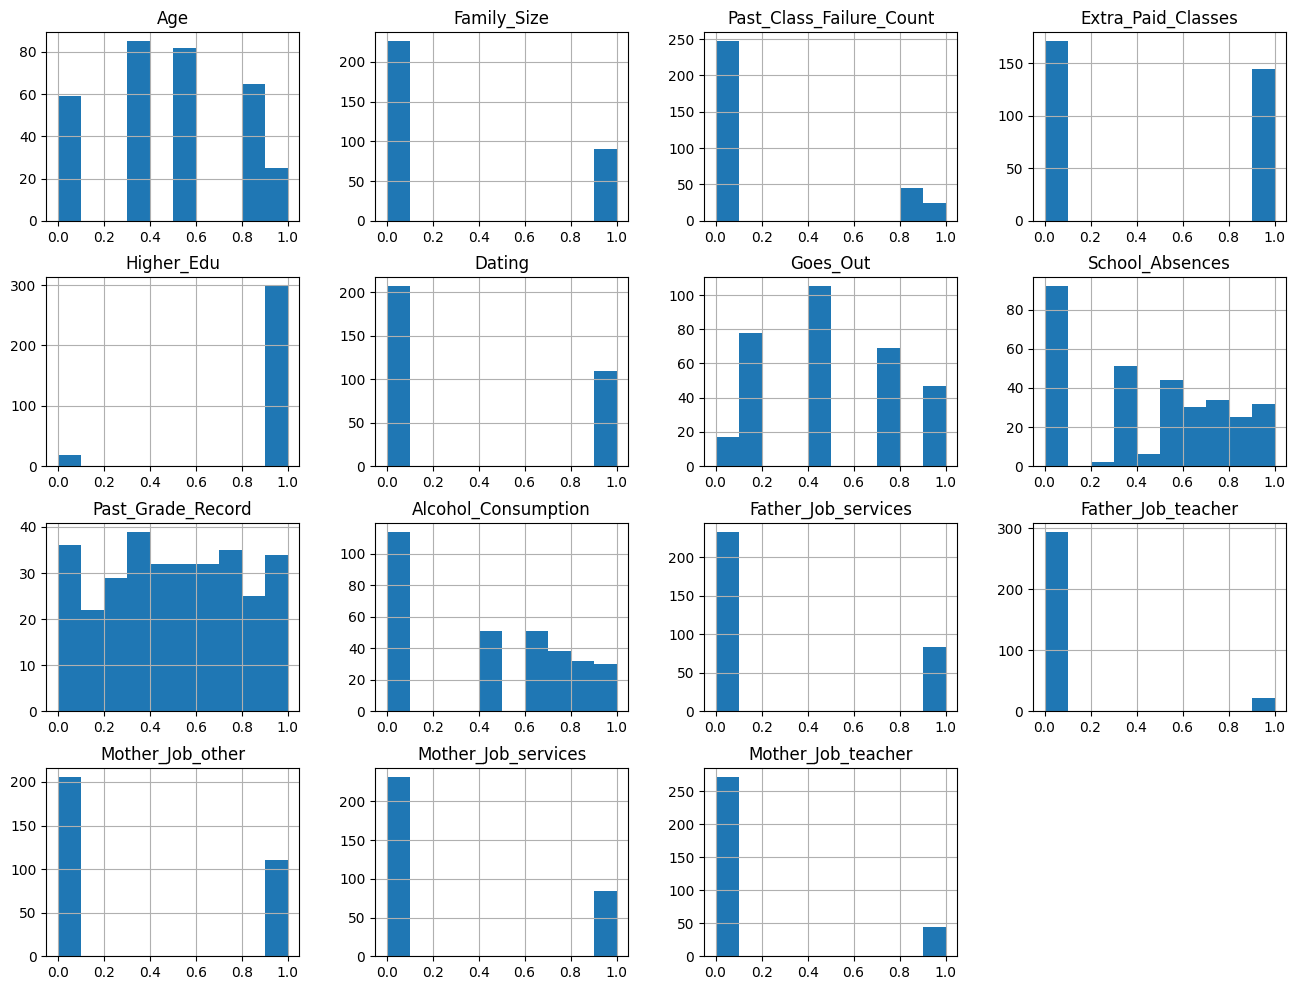

In [169]:
x_train.hist(figsize=(16, 12))
plt.show()

In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

### Model Training

In [209]:
lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=300, oob_score=True, random_state=42, n_jobs=6)
knr = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=6)
svr = LinearSVR(random_state=42)

In [210]:
lr.fit(x_train, y_train)
rfr.fit(x_train, y_train)
knr.fit(x_train, y_train)
svr.fit(x_train, y_train)

LinearSVR(random_state=42)

In [211]:
lr_preds = lr.predict(x_test)
rfr_preds = rfr.predict(x_test)
knr_preds = knr.predict(x_test)
svr_preds = svr.predict(x_test)

In [212]:
from sklearn.metrics import r2_score, mean_absolute_error

In [213]:
print(f'LR Accuracy: {round(r2_score(y_test, lr_preds), 3)*100}%')
print(f'RFR Accuracy: {round(r2_score(y_test, rfr_preds), 2)*100}%')
print(f'KNR Accuracy: {round(r2_score(y_test, knr_preds), 3)*100}%')
print(f'SVR Accuracy: {round(r2_score(y_test, svr_preds), 3)*100}%')

LR Accuracy: 74.8%
RFR Accuracy: 82.0%
KNR Accuracy: 38.0%
SVR Accuracy: 74.5%


In [219]:
mean_absolute_error(y_test, rfr_preds)

1.1780168776371307

In [218]:
from pickle import dump

# with open('../models/trained_rfr_model.pkl', 'wb') as f:
#     dump(rfr, f)

# with open('../models/trained_lr_model.pkl', 'wb') as f:
#     dump(lr, f)

# with open('../models/trained_svr_model.pkl', 'wb') as f:
#     dump(svr, f)

### Plotting the predictions vs original target values

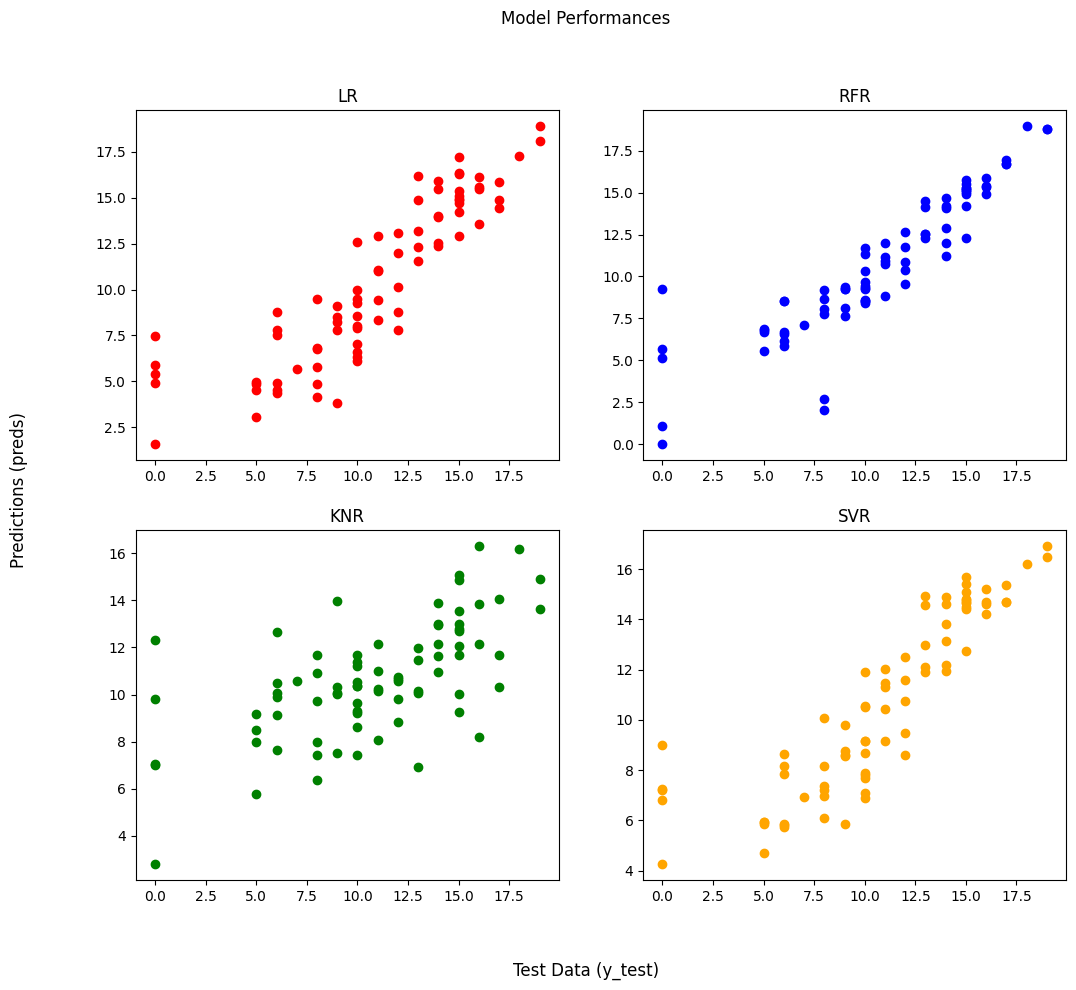

In [216]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Model Performances')
fig.supxlabel('Test Data (y_test)')
fig.supylabel('Predictions (preds)')

axs[0][0].scatter(y_test, lr_preds, color='red')
axs[0][0].set_title('LR')
axs[0][1].scatter(y_test, rfr_preds, color='blue')
axs[0][1].set_title('RFR')
axs[1][0].scatter(y_test, knr_preds, color='green')
axs[1][0].set_title('KNR')
axs[1][1].scatter(y_test, svr_preds, color='orange')
axs[1][1].set_title('SVR')

plt.savefig('../reports/Models_Performance.png')